# Fire Hazard Incidents Analytics Pipeline
## Ignition Loss vs Average Losses in dollars

## Importing Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

from storedb import save_in_db, IMG_PATH

## Creating Spark Session and using all available cores

In [2]:
%%time
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:47:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/11 20:47:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/11 20:47:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/12/11 20:47:59 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/12/11 20:47:59 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
CPU times: user 21.4 ms, sys: 27.3 ms, total: 48.8 ms
Wall time: 2.36 s


## Loading firefighter casuality and basic module data

In [3]:
%%time
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")
fire_incidents_df = spark.read.options(delimiter="^", header=True).csv("fireincident.txt")

CPU times: user 3.66 ms, sys: 3.01 ms, total: 6.67 ms
Wall time: 2.86 s


In [4]:
%%time
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

CPU times: user 5.73 ms, sys: 3.97 ms, total: 9.7 ms
Wall time: 96.4 ms


In [5]:
%%time
ignition_cause = fire_incidents_df.na.drop(subset=("CAUSE_IGN"))

ignition_cause_vs_loss = total_loss.join(ignition_cause, total_loss.INCIDENT_KEY == ignition_cause.INCIDENT_KEY)
cause_loss_df = ignition_cause_vs_loss.groupBy("CAUSE_IGN").agg(F.sum("TOTAL_LOSS").alias("DLR_LOSS"))
p_cause_loss_df = cause_loss_df.toPandas()
p_cause_loss_df["DLR_LOSS"] = p_cause_loss_df["DLR_LOSS"]/1e09

CPU times: user 264 ms, sys: 83 ms, total: 347 ms
Wall time: 6.74 s


CPU times: user 82.5 ms, sys: 29.6 ms, total: 112 ms
Wall time: 136 ms


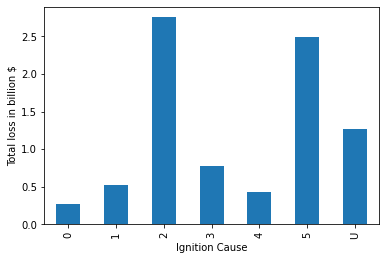

In [6]:
%%time
p5 = p_cause_loss_df.sort_values(by="CAUSE_IGN").plot(x="CAUSE_IGN", y="DLR_LOSS", xlabel="Ignition Cause", ylabel = "Total loss in billion $", kind="bar", legend = False)
fig5 = p5.get_figure()
fig_name = "ign_cause_dollar_loss.png"
fig5.savefig(f"{IMG_PATH}{fig_name}")

# saving to db
save_in_db(fig_name, "ignition_cause_vs_dollar_losses")
